# Week 4

## Prelude: Regular Expressions


* What is Regular Expressions?
    * A regular expression is a sequence of characters that specifies a search pattern in text. Usually such patterns are used by string-searching algorithms for "find" or "find and replace" operations on strings, or for input validation. Regular expression techniques are developed in theoretical computer science and formal language theory

## Part A:  Download the Wikipedia pages of characters

In [1]:
################## imports  ####################################
import urllib.request
import pandas as pd
import json
import os
from tqdm.notebook import tqdm
import networkx as nx
import re
import numpy as np
import matplotlib.pyplot as plt

###############################################################
#################### Functions ################################

def flatten_and_remove_empty(l):
    return [item for sublist in l for item in sublist if item != '']

def check_if_present_in_links(dc_df, marvel_df, link):
    target = dc_df.loc[dc_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    target = marvel_df.loc[marvel_df['WikiLink'] == link]
    if not target.empty:
        return str(target['CharacterName'].values[0])
    return None

def check_if_present_in_names(dc_df, marvel_df, name):
    target = dc_df.loc[dc_df['CharacterName'] == name]
    if not target.empty:
        return name
    target = marvel_df.loc[marvel_df['CharacterName'] == name]
    if not target.empty:
        return name
    
    return None
    
def get_name_from_link(df, link):
    target = df.loc[df['WikiLink'] == link]
    return target['CharacterName']
    
def get_charactername_from_filename(filename):
    return filename.replace("_*_"," ").replace("-*-","/").replace(".txt","")

def get_filename_from_charactername(character_name):
    return character_name.replace(" ", "_*_").replace("/","-*-")

def download_and_save(folder_name,character_name, wikilink):
    
    character_name = get_filename_from_charactername(character_name)
    filename = character_name+".txt"
    
    if os.path.exists(folder_name+"/"+filename):
        return
    
    baseurl = "https://en.wikipedia.org/w/api.php?"
    action = "action=query"
    titles = "titles="+wik
    content = "prop=revisions&rvprop=content&rvslots=main"
    dataformat ="format=json"
    
    query = "{}{}&{}&{}&{}".format(baseurl, action, content, titles, dataformat)
    
    
    
    try:
        wikiresponse = urllib.request.urlopen(query)
    except: #here one specific except
        #skip it
        return
    wikidata = wikiresponse.read()
    wikitext = wikidata.decode('utf-8')
    
    
    f = open(folder_name+"/"+filename, "w")
    f.write(wikitext)
    f.close()
###############################################################
    
###############################################################
################### Global Definitions ########################
dc_unv = "DC"
marvel_unv = "Marvel"
universes = [dc_unv, marvel_unv]
data_folder = "../Data/"
###############################################################




In [2]:
# Some preprocessing

marvel_characters_file = "../Data/marvel.pkl"
dc_characters_file = "../Data/dc.pkl"

marvel_characters_df = pd.read_pickle(marvel_characters_file)
dc_characters_df = pd.read_pickle(dc_characters_file)

#cleaning from NaN values
print(marvel_characters_df.shape)
marvel_characters_df = marvel_characters_df.dropna()
marvel_characters_df = marvel_characters_df.reset_index(drop=True)
print(marvel_characters_df.shape)

#cleaning from NaN values
print(dc_characters_df.shape)
dc_characters_df = dc_characters_df.dropna()
dc_characters_df = dc_characters_df.reset_index(drop=True)
print(dc_characters_df.shape)

#replace spaces with underscores in links
dc_characters_df['WikiLink'] = dc_characters_df['WikiLink'].apply(lambda x: x.replace(" ","_"))


(2373, 3)
(1785, 3)
(771, 3)
(518, 3)


In [3]:
#################### Download them ############################

# if not os.path.exists(dc_unv):
#     os.mkdir(dc_unv)

# for character_name, wikilink in tqdm(zip(dc_characters_df['CharacterName'], dc_characters_df['WikiLink'])):
#     download_and_save(dc_unv,character_name, wikilink) 
    
# if not os.path.exists(marvel_unv):
#     os.mkdir(marvel_unv)

# for character_name, wikilink in tqdm(zip(marvel_characters_df['CharacterName'], marvel_characters_df['WikiLink'])):
#     download_and_save(marvel_unv,character_name, wikilink)
    

In [4]:
# Graph Creation

G = nx.DiGraph()


# Create Nodes
for universe_name in universes:
    if universe_name == dc_unv:
        df = dc_characters_df
    else:
        df = marvel_characters_df
    universe_folder = os.path.join(data_folder, universe_name)
    for character_name in df['CharacterName']:
        # count words
        fn = os.path.join(universe_folder, get_filename_from_charactername(character_name))
        # checking if it is a file
        word_count = 0
        if os.path.isfile(fn):
            f = open(fn, "r")
            text = f.read()
            word_count = len(re.findall(r'\w+', text))
            f.close()
        G.add_node(character_name,universe=universe_name, wc = word_count)

# all_names_and_links = ""
# for character_name, wikilink in tqdm(zip(dc_characters_df['CharacterName'], dc_characters_df['WikiLink'])):
#     all_names_and_links += ","+character_name+","+wikilink
# for character_name, wikilink in tqdm(zip(marvel_characters_df['CharacterName'], marvel_characters_df['WikiLink'])):
#     all_names_and_links += ","+character_name+","+wikilink
    
# all_names_and_links = all_names_and_links.replace(" ", "").replace('r\([\w\-_\#(\)\s]+\)',"")
# k
print("Number of Nodes before adding edges  = {}".format(G.number_of_nodes()))


for unv_name in universes:
    if unv_name == dc_unv:
        df = dc_characters_df
    else:
        df = marvel_characters_df
    universe_folder = os.path.join(data_folder, unv_name)
    for filename in tqdm(os.listdir(universe_folder)):
        fn = os.path.join(universe_folder, filename)
        # checking if it is a file
        if os.path.isfile(fn):
            f = open(fn, "r")
            text = f.read()
            f.close()

            character_name = get_charactername_from_filename(filename)
            wikilinks = re.findall(r'\[\[([\w\-_\#(\)\s]+)\|?([\w\-\s#\(\)]*)\]\]', text)
            wikilinks = flatten_and_remove_empty(wikilinks)
            wikilinks_for_names = [wikilink.replace("[","").replace("]","") for wikilink in wikilinks]
            wikilinks_for_links = [wikilink.replace(" ", "_") for wikilink in wikilinks_for_names]
            for i in range(0, len(wikilinks_for_names)):
                name = check_if_present_in_names(dc_characters_df, marvel_characters_df, wikilinks_for_names[i])
                if name != None:
                    G.add_edge(character_name, name) 
                    continue
                name = check_if_present_in_links(dc_characters_df, marvel_characters_df, wikilinks_for_links[i])
                if name != None:
                    G.add_edge(character_name, name) 
                    
                    
print(G.number_of_nodes())
print(G.number_of_edges())
                    

Number of Nodes before adding edges  = 2276


  0%|          | 0/518 [00:00<?, ?it/s]

  0%|          | 0/1784 [00:00<?, ?it/s]

2276
30869


2276
30869
1486


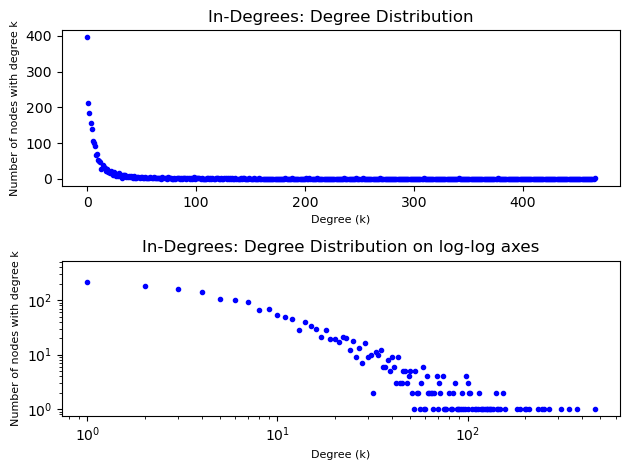

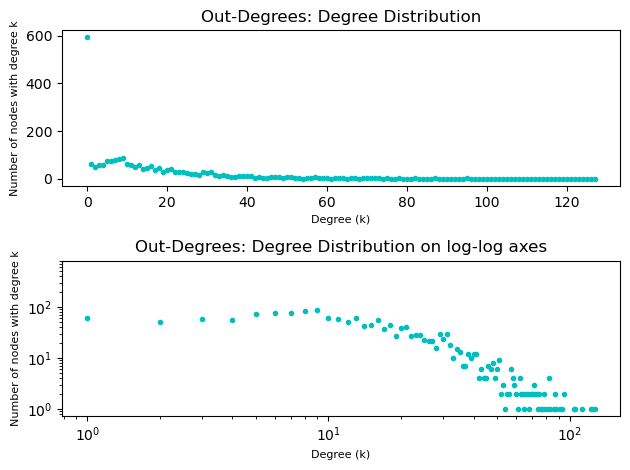

In [5]:

print(G.number_of_nodes())
print(G.number_of_edges())

def plot_degree_distribution(degrees, title, color):
    counts, limits = np.histogram(degrees, degrees[0])

    x = limits[:len(counts)]
    y = counts

    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(x, y, color)
    ax1.set_title(title)
    ax1.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax1.set_xlabel('Degree (k)',fontsize=8)

    ax2 =plt.subplot(2, 1, 2)
    ax2.loglog(x, y, color)
    ax2.set_title(title + ' on log-log axes')
    ax2.set_ylabel('Number of nodes with degree k',fontsize=8)
    ax2.set_xlabel('Degree (k)',fontsize=8 )

    plt.tight_layout()
    plt.show()

    
number_of_bidirectional_edges = 0
for (x,y) in G.edges():
    if G.nodes[x]['universe'] != G.nodes[y]['universe']:
        number_of_bidirectional_edges+=1
        
print(number_of_bidirectional_edges)
    
in_degrees = sorted(list(G.in_degree()),key=lambda d: d[1], reverse=True)
out_degrees = sorted(list(G.out_degree()),key=lambda d: d[1], reverse=True)

in_only_degrees = [val for node,val in in_degrees]
out_only_degrees = [val for node,val in out_degrees]
    

plot_degree_distribution(in_only_degrees, "In-Degrees: Degree Distribution", 'b.')

plot_degree_distribution(out_only_degrees, "Out-Degrees: Degree Distribution", 'c.')

In [6]:
def find_five_most_connected(universe, degrees):
    most_connected = []
    count = 0
    for hero, degree in degrees:
        if G.nodes[hero]['universe'] == universe:
            count+=1
            most_connected += (hero,degree)
        if count >= 5:
            break
    return most_connected

universes = ["Marvel", "DC"]
for un in universes:
    print("{}'s 5 most connceted heroes based on incoming degree".format(un))
    print(find_five_most_connected(un, in_degrees))
    print("{}'s 5 most connceted heroes based on outgoing degree".format(un))
    print(find_five_most_connected(un, out_degrees))

Marvel's 5 most connceted heroes based on incoming degree
['Spider-Man', 467, 'Captain America', 377, 'Iron Man', 341, 'Hulk', 309, 'Wolverine', 269]
Marvel's 5 most connceted heroes based on outgoing degree
['Captain America', 128, 'Iron Man', 124, 'Wolverine', 123, 'Jackal', 113, 'Norman Osborn', 105]
DC's 5 most connceted heroes based on incoming degree
['Superman', 253, 'Batman', 247, 'Wonder Woman', 158, 'Lex Luthor', 141, 'Green Lantern', 127]
DC's 5 most connceted heroes based on outgoing degree
['Deathstroke', 79, 'Red Tornado', 58, 'Vampirus', 56, 'Black Adam', 53, 'Vince Everett', 52]


In [7]:
#for the whole network
print("5 most connceted heroes in the whole network based on incoming degree")
print(in_degrees[:5])
print("5 most connceted heroes in the whole network based on outgoing degree")
print(out_degrees[:5])

5 most connceted heroes in the whole network based on incoming degree
[('Spider-Man', 467), ('Captain America', 377), ('Iron Man', 341), ('Hulk', 309), ('Wolverine', 269)]
5 most connceted heroes in the whole network based on outgoing degree
[('Captain America', 128), ('Iron Man', 124), ('Wolverine', 123), ('Jackal', 113), ('Norman Osborn', 105)]


# Week 5

## Part A

### Exercise 1: Build the right graph for visualization.

In [8]:
#Remove Isolated
isolated_nodes = nx.isolates(G)
print(len(list(isolated_nodes)))

G.remove_nodes_from(list(isolated_nodes))

182


In [9]:
print("Number of connected components: {}".format(nx.number_weakly_connected_components(G)))

Number of connected components: 186


In [10]:
ccs = [len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)]
print(ccs)

maxcc = max(nx.weakly_connected_components(G), key=len)

WCC = G.subgraph(maxcc)

print("Number of Nodes of Largest Connected Component = {}".format(WCC.number_of_nodes()))
print("Number of Edges of Largest Connected Component = {}".format(WCC.number_of_edges()))

[2090, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Number of Nodes of Largest Connected Component = 2090
Number of Edges of Largest Connected Component = 30866


### Exercise 2: Let's build a simple visualization of network

1. For the sake of the visualisation, let's convert our network to undirected graph (tip: There is a NetworkX command to help you). Note: Keep the directed graph, we will use it in couple of the following exercises

Number of edges after converting to undirected = 26800


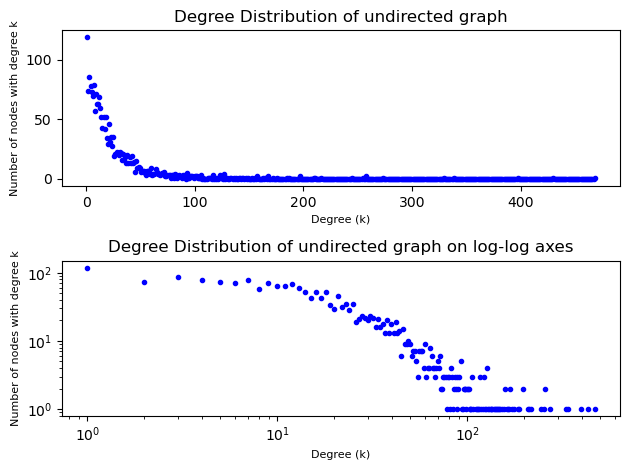

In [11]:
WCC_undirected = WCC.to_undirected()

print("Number of edges after converting to undirected = {}".format(WCC_undirected.number_of_edges()))


#Degree Distribution

degrees = sorted(list(WCC_undirected.degree()),key=lambda d: d[1], reverse=True)

degrees_only = [val for node,val in degrees]


plot_degree_distribution(degrees_only, "Degree Distribution of undirected graph", 'b.')

2. Use the NetworkX command nx.draw_kamada_kawai to draw the network resulting undirected. (You can find background on the algorithm here.)
    * Node color should depend on the universe attribute (i.e. use different colors for DC and Marvel universe)
    * Set up your plot so that node-size depends on the node degree
    * Optional: Set up you plot so that edge color depends on the universe attribute. If an edge connects two nodes from Marvel universe assign color_a, if the edge connects two nodes from DC universe assign color_b, in case a link connects nodes from disparate universes, cases assign color_c. (Here, you get to decide on the colors.)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


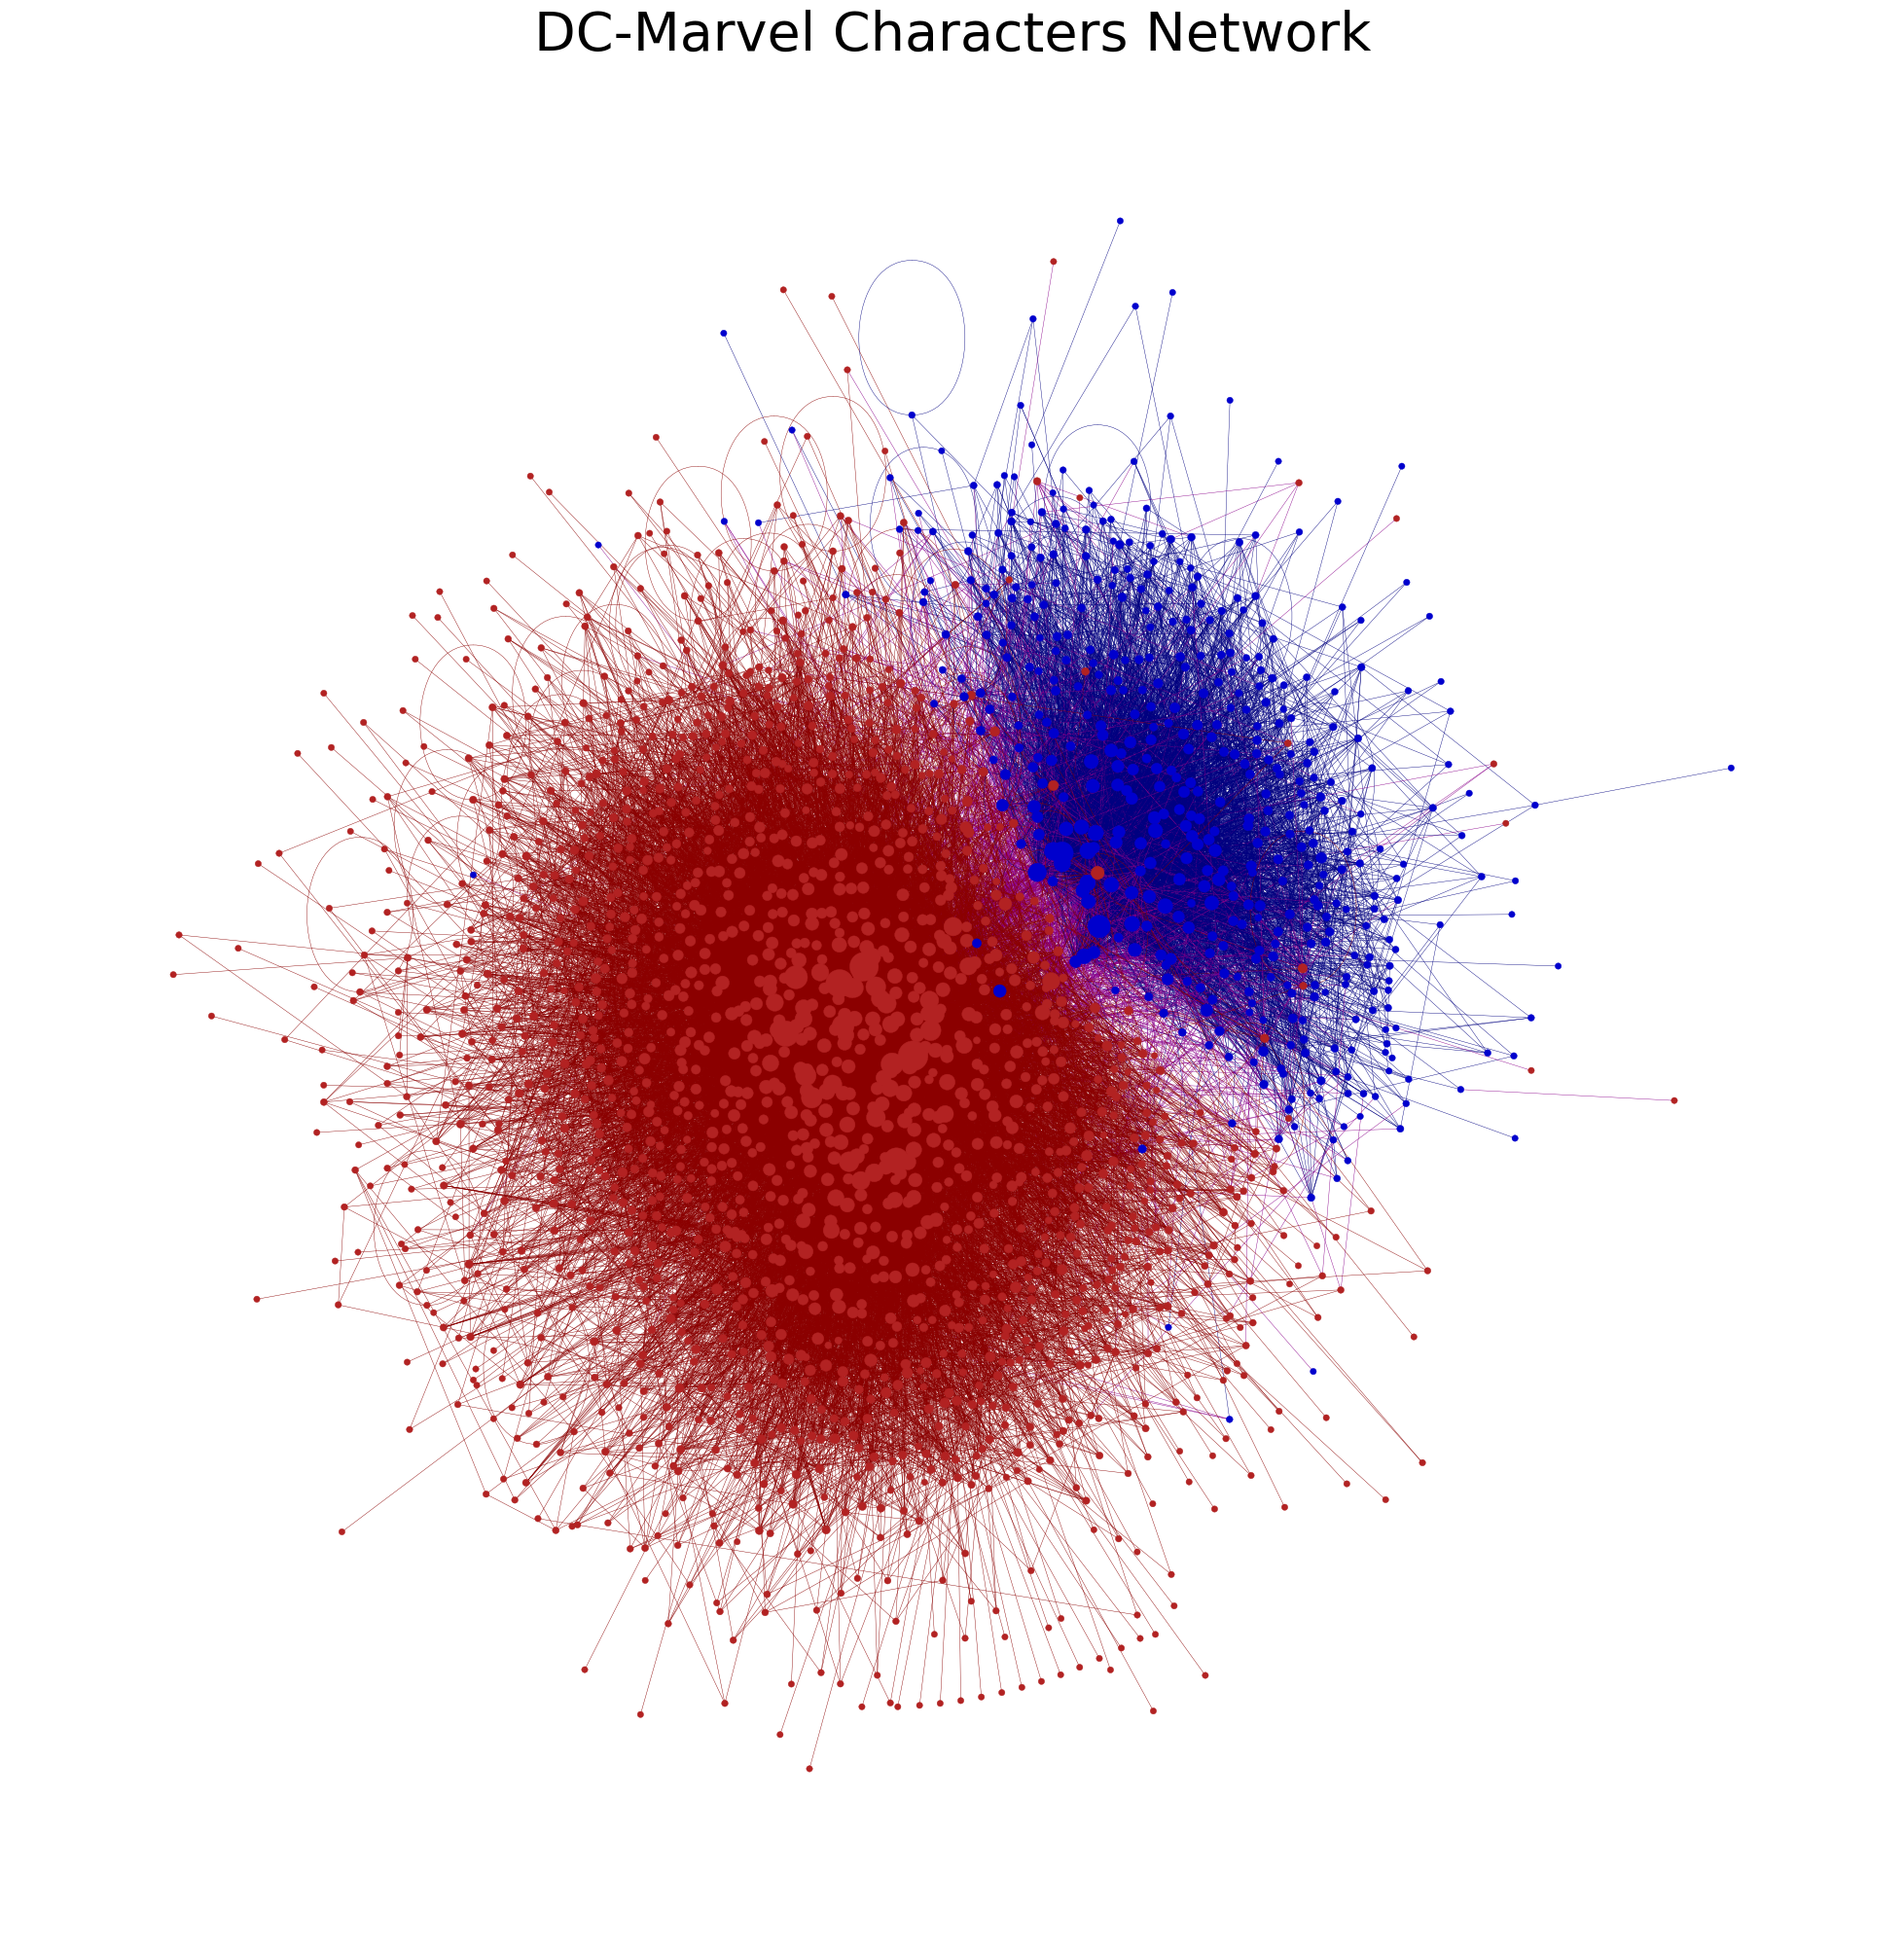

In [12]:
# #0000CD medium blue DC
# #B22222 fiberick red Marvel
# #8B0000 dark red
# navy #000080
# dark magenta #8B008B
# import random
# set_of_nodes = set()
# list_of_all_nodes = list(WCC_undirected.nodes)
# for i in range(0,int(WCC_undirected.number_of_nodes()/2)):
#     set_of_nodes.add(random.choice(list_of_all_nodes))

# TestGraph = WCC_undirected.subgraph(set_of_nodes)
    
plt.figure(figsize=(25,25))
ax = plt.gca()
ax.set_title('DC-Marvel Characters Network',fontsize = 40)   

node_sizes = [val+20 for node, val in WCC_undirected.degree()]
node_colors = ['#0000CD' if node[1]['universe'] == "DC" else '#B22222' for node in WCC_undirected.nodes(data=True)]
edge_colors = ['#000080' if WCC_undirected.nodes[node1]['universe'] == WCC_undirected.nodes[node2]['universe'] == "DC"\
               else '#8B0000' if WCC_undirected.nodes[node1]['universe'] == WCC_undirected.nodes[node2]['universe'] == "Marvel" \
               else '#8B008B' for node1,node2 in WCC_undirected.edges]

args = {
'node_color': node_colors,
'edge_color':edge_colors,
'node_size':node_sizes,
'width':0.3,
'linewidths':0.3,
}
#nx.draw_kamada_kawai(WCC_undirected, node_color=node_colors, edge_color=edge_colors, node_size=node_sizes, width=0.3, linewidths=0.3, ax=ax)
nx.draw_kamada_kawai(WCC_undirected,ax=ax, **args)
plt.show()

lallalal

### **Exercise 3:** We can make even better visualisations with ForceAtlas2 package. (By "better" we mean "more beautiful" of course, but better also means more useful in terms of understanding the network. A good visualization that really captures structure in the graph can help you understand the network. )

1. The Force Atlas 2 algorithm helps calculate more aesthetically pleasing positions for the nodes (see what the result looks like below). 2.You can install the package in conda typing something along the lines of conda install -c conda-forge fa2 in the terminal. The github page explains how to use the package to get coordinates for each node. You can then feed those coordinates to NetworkX (see below).
* Visualize the network using the NetworkX draw function, and node-coordinates from the force atlas algorithm. As in the previous Exercise:
    * Node color should depend on the universe attribute (i.e. use different colors for DC and Marvel universe)
    * Node size should depend on the node degree
    * Optional: Edge colour should depend on the universe attribute. If an edge connects nodes from Marvel universe assign color_a, if the edge connects nodes from DC universe assign color_b, in other cases assign color_c
* Play with the force atlas algorithm parameters to obtain a visualization you like. It may look similar to the one below (but not necessarily).
* Describe the structure you observe. Can you see that the nodes seperate into two separate clusters? Can you see high-degree nodes? In the plot below, the red nodes seem to split into two sub-clusters: What's going on there?

In [ ]:
from fa2 import ForceAtlas2

node_sizes = [val+20 for node, val in WCC_undirected.degree()]
node_colors = ['#0000CD' if node[1]['universe'] == "DC" else '#B22222' for node in WCC_undirected.nodes(data=True)]
edge_colors = ['#000080' if WCC_undirected.nodes[node1]['universe'] == WCC_undirected.nodes[node2]['universe'] == "DC"\
               else '#8B0000' if WCC_undirected.nodes[node1]['universe'] == WCC_undirected.nodes[node2]['universe'] == "Marvel" \
               else '#8B008B' for node1,node2 in WCC_undirected.edges]

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=1.0,
                        strongGravityMode=False,
                        gravity=-1,

                        # Log
                        verbose=True)

# plt.figure(figsize=(25,25))
# ax = plt.gca()
# ax.set_title('DC-Marvel Characters Network',fontsize = 40) 
args = {
'node_color': node_colors,
'edge_color':edge_colors,
'node_size':node_sizes,
'width':0.3,
'linewidths':0.3,
}

figure = plt.figure(figsize=(40,20))
# plt.savefig(figure, dpi=1200)
ax = plt.gca()
ax.set_title('DC-Marvel Characters Network',fontsize = 40) 

positions = forceatlas2.forceatlas2_networkx_layout(WCC_undirected, pos=None, iterations=2000)
nx.draw(WCC_undirected,positions, **args, ax=ax)

plt.show()

 99%|█████████▉| 1988/2000 [01:01<00:00, 34.96it/s]

**Exercise 4:** We continue with a qualitative inspection of the Wikipedia pages. Inspecting the data will develop intuitions that will help us to intepret our quantitative results. We investigate the reasons for links between characters to exist on Wikipedia.

1. Consider the nodes with highest in-degree in the network. Open the corresponding Wikipedia page.
    * Consider the set of neighbours pointing towards the node found above.
    * What is the relation between the characters you identified and their network neighbours? (e.g. do they appear in the same comics?, are they opponents?, etc ...). You don't need to come up with a grand theory of comics here, I just want you to think about how links arise, why the links are there.
    * Repeat the exercise for the largest out-degree node.
    * Are there differences between reasons for out- and in-links? Again, there's no right answer here. I just want you to think about some of the reasons why links may occur in Wikipedia
2. Are there any nodes with high out-degree and with few incoming connections? If yes, open WikiPages of such characters and explain what happens?
3. Are there any nodes with high in-degree and few outcoming connections? Again, open WikiPages of such characters and explain what happens?

**Answer:**

## Part B: Advanced tools

### **Exercise 5:** Last time we visually analyzed (plotted) the degree distributions of our network. Now, let's analyze it using some of the tools from previous lectures. For this exercise we are going to look at the directed graph (rememeber, we asked you to keep one?).

1. What are the average, median, mode, minimum and maximum value of the in-degree? And of the out-degree? How do you intepret the results?
    * On top of that, calculate same statistics separately for the network that is spanned only by DC Characters (we call this the DC-network), and only by the Marvel characters (the Marvel-network). How do you interpret the results?
2. Let's also look at the exponent of the degree distribution
    * To calculate it, you can install powerlaw package (I could not install in conda, so I used pip install powerlaw)
    * Use powerlaw.Fit(degree).alpha for fitting
    * Find the degree exponent for in-, out- and total- degree distribution. What does it say about our network?
    * When analyzing the plots of in- and out- degree distribution last week, did you come up to the same conclusions?
    * A long time ago, a group of scientists analyzed the network spanned by *all of Wikipedia (the paper is called Wikipedias: Collaborative web-based encyclopedias as complex networks; to access this paper, use findit.dtu.dk or read the preprint on arXiv). Do your findings correspond to the results described in Chapter III.A of that paper? If not, try to give your explanation of why?
3. Create a scatter plot of the the in- versus out- degree for all characters. Comment on the relation between the two.
4. Plot a heatmap (Hint here) of the the in- versus out- degree for all characters. What is the advantage of using a heatmap over the scatter plot?
5. Why do you think I want you guys to use a directed graph? Are there questions we can ask using the directed graph that are not possible to answer in the undirected version. Which questions? Can you think of examples when the in/out distinction doesn't matter.
6. We have one more metric that we did not use. The node-attribute content lenght. There are two things we can investigate here.
    * Firstly, we can verify that more text means more links. If that's true the length should correlate with out-degree. Does it?
    * Secondly, and more interestingly, it could be that longer texts means more famous characters. And that means more in-links.
    * How should you test this? Well, here you are allowed to be creative. You may choose the method of your liking to study this question (e.g. look at it visually, test the correlation using spearman or pearson correlations, fit a curve to the data, you decide). Once you've tested, let me know. Are both questions true? If yes, which phenomenon is stronger? Explain your results in your own words

## 5.1.

In [ ]:
def print_statistics(my_graph, name):
    
    in_degrees = np.array([val for node,val in list(my_graph.in_degree())])
    out_degrees = np.array([val for node,val in list(my_graph.out_degree())])
    
    print(f"\nDegree Statistics of the {name}.")
    print("\tIn-Degree Statistics:")
    print(f"\t\tAverage = {np.mean(in_degrees):.2f}, Median = {np.median(in_degrees):.2f},Mode={stats.mode(in_degrees)},\
                            \n\t\tMinimum = {np.min(in_degrees):.2f}, Maximum = {np.max(in_degrees):.2f}.")
    print("\n\tOut-Degree Statistics:")
    print(f"\t\tAverage = {np.mean(out_degrees):.2f}, Median = {np.median(out_degrees):.2f},Mode={stats.mode(out_degrees)},\
                            \n\t\tMinimum = {np.min(out_degrees):.2f}, Maximum = {np.max(out_degrees):.2f}.")
    
from scipy import stats
in_degrees_np = np.array(in_only_degrees)
out_degrees_np = np.array(out_only_degrees)

DC_nodes = (
    node
    for node, data
    in WCC.nodes(data=True)
    if data.get("universe") == "DC"
)
DC_subgraph = WCC.subgraph(DC_nodes)

Marvel_nodes = (
    node
    for node, data
    in WCC.nodes(data=True)
    if data.get("universe") == "Marvel"
)
Marvel_subgraph = WCC.subgraph(Marvel_nodes)


print_statistics(WCC, "DC - Marvel Network")

print_statistics(DC_subgraph, "DC Network")

print_statistics(Marvel_subgraph, "Marvel Network")

## 5.2.

In [ ]:
!pip install powerlaw

In [ ]:
import powerlaw 

in_degrees = np.array([val for node,val in list(WCC.in_degree())])
out_degrees = np.array([val for node,val in list(WCC.out_degree())])
    
fit = powerlaw.Fit(in_degrees)

print(f"{fit.alpha:.2f}")

fit = powerlaw.Fit(out_degrees)

print(f"{fit.alpha:.2f}")

## 5.3

In [ ]:
plt.figure(figsize=(15,15))
plt.scatter(in_degrees, out_degrees,alpha=0.5)
plt.xlabel("In Degree")
plt.ylabel("Out Degree")
plt.show()

## 5.4

In [ ]:
heatmap, xedges, yedges = np.histogram2d(in_degrees, out_degrees, bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
from scipy.ndimage.filters import gaussian_filter

plt.figure(figsize=(15,15))
heatmap = gaussian_filter(heatmap, sigma=16)
plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.legend()
plt.show()


## 5.5

Answer:

## 5.6

### Exercise 6: Centralities, assortativity and more.

Earlier, we found the most connected nodes (using degree centrality).

Now let's dig in and try to understand more about the network using more advanced features.

Note: Not all of the measures we'll be considering below are defined for directed graphs. Only use the undirected graph when explicitly stated in the exercise. Meanwhile, for this exercise use either the DC or Marvel Network alone (i.e. only a single universe). This it will help you to see the differences).

1. Find the 5 most central characters according to degree centrality.
    * Repeat Exercise 2 or 3 from part A above for your new sub-network (depending on which visualization method you liked the most), but with our new network.
2. Find the 5 most central characters according to betweenness centrality.
    * Repeat Exercise 2 or 3 once again. However, this time use betweenness centrality to define the size of the node.
    * What role do you imagine characters with high wikipedia graph betweenness centrality play in the network?
3. Find the 5 most central characters according to eigenvector centrality. Calculate centrality corresponding to both in- and out-edges (see NetworkX documentation for details).
    * Repeat Exercise 2 or 3 one final time (depending on which visualization method you liked the most). However, this time use eigenvector centrality to define the size of the node.
    * What role do you imagine characters with high wikipedia graph eigenvector centrality play? Describe what is different about betweenness centrality and eigenvector centrality using your visualizations as examples.
4. Plot the betweenness centrality of nodes vs their degree centrality. Is there a correlation between the two? Did you expect that? Why?
    * Repeat the scatter plot using eigenvector centrality instead of betweenness centrality. Do you observe any difference relative to above? Why?
5. Is the undirected version of the graph assortative with respect to degree? (e.g. do high-degree characters tend to link to other high-degree characters, and low-degree characters to other low-degree characters?). Provide an interpretation of your answer.
6. Is the undirected version of the graph assortative with respect do the content length nodal properties? (e.g. do characters with long Wikipedia pages tend to link to other charakters with long Wiki-pages, and vice versa?. Hint: Use this function. Provide an interpretation of your answer.
7. What is the average shortest path length? Is it similar to the one of a random graph with the same number of nodes  and probablity of connection ?
    * Take a look at the distribution of shortest paths for the two networks (create a histogram for each network) to better compare and contrast. Explain what you see in your own words.
* Optional (but cool). What about betweenness centrality in the full network? Create a visualization of the network using Force Atlas 2, where you set the size of nodes to scale according to their betweenness centrality. Describe in your own words what you learn from that plot.